# "Ave, celeba!" (averaging noised images of celebrity faces) dataset
**Warning!** This code is provided only for completeness and is not intented to be used to recreate the *Ave, celeba!* dataset. Just download the dataset here.

In [1]:
import sys, os
sys.path.append('../')

import numpy as np
import torch
from torch import nn
import torchvision

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from src.tools import read_image_folder, freeze
from src.icnn import ConvICNN64, CompositeICNN, GlobalPermutation, GlobalReflection, View
from tqdm import tqdm_notebook
from PIL import Image

import gc

In [2]:
gpu_id = 0

assert torch.cuda.is_available()
torch.cuda.set_device(gpu_id)

In [3]:
# Path to the folder containing 202599 64x64 RGB Celeba images
path_in = '../../data/celeba_aligned/all/'
path_out = '../../data/ave_celeba/'

for k in range(3):
    path = os.path.join(path_out, '{}'.format(k))
    if not os.path.exists(path):
        os.makedirs(path)

## Reading original aligned CelebA faces dataset

In [4]:
faces = np.array([
    np.array(im, dtype=np.uint16) for im in read_image_folder(path_in, n_jobs=40, verbose=True)
]).astype(np.float32).transpose(0, 3, 1 ,2)

# Normalization to [-1, 1]
faces = 2 * (faces / 255) - 1

assert faces.shape == (202599, 3, 64, 64), 'Are you sure this is Aligned Celeba faces 64x64 dataset?'

## Randomly splitting the dataset

In [5]:
np.random.seed(0xBADBEEF)
idx = np.random.permutation(list(range(len(faces)))).tolist()
parts_idx = []
for k in range(3):
    parts_idx.append(idx[k*len(faces)//3:(k+1)*len(faces)//3])

## Setting up basis potentials
Pre-trained models are taken from the Wasserstein-2 benchmark https://arxiv.org/abs/2106.01954

In [6]:
class DecolorizerRandom(nn.Module):
    def __init__(self):
        super(DecolorizerRandom, self).__init__()
        self.alpha = np.random.dirichlet([1, 1, 1])
        
    def forward(self, input):
        decolorized_input = input[:,0] * self.alpha[0] +  input[:,1] * self.alpha[1]+ input[:,2] * self.alpha[0] 
        output = decolorized_input[:,None,:,:].repeat(1,3,1,1)
        return output

class Decolorizer(nn.Module):
    def __init__(self):
        super(Decolorizer, self).__init__()
        
    def forward(self, input):
        return (input.sum(dim=1, keepdims=True) / 3.).repeat(1,3,1,1)

In [7]:
# Initializing linears layers
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
L1 = nn.Sequential(DecolorizerRandom(), GlobalPermutation(64*64*3), GlobalReflection(64*64*3),)
torch.manual_seed(0xC0FFEE); np.random.seed(0xC0FFEE)
L2 = nn.Sequential(Decolorizer(), GlobalPermutation(64*64*3), GlobalReflection(64*64*3),)

# Loading pre-train potentials borrowed from the Wasserstein-2 Benchmark
D1, D2 = ConvICNN64(), ConvICNN64()
D1.load_state_dict(torch.load('../benchmarks/CelebA64/Early_v1_conj.pt'))
D2.load_state_dict(torch.load('../benchmarks/CelebA64/Early_v2_conj.pt'))

# Composing the convex potentials with linear transforms
D1, D2 = CompositeICNN(L1, D1, strong_convexity=0.001).cuda(), CompositeICNN(L2, D2, strong_convexity=0.001).cuda()
freeze(D1); freeze(D2)

In [8]:
def invert_potential(X, D, beta=0.5, inv_max_iter=1000, inv_tol=1e-4, inv_lr=2e-2):
    '''Function to invert the gradient of a convex potential'''
    X_inv = X.detach().clone()
    X_inv.requires_grad_(True)

    opt = torch.optim.Adam([X_inv], lr=inv_lr)
    for it in range(inv_max_iter):
        opt.zero_grad()
        loss = .5 * beta * (X_inv ** 2).flatten(start_dim=1).sum(dim=1).mean() + \
        (1 - beta) * D(X_inv).mean() - (X * X_inv).flatten(start_dim=1).sum(dim=1).mean()
        loss.backward(); opt.step()

        if torch.sqrt((X_inv.grad ** 2).flatten(start_dim=1).sum(dim=1)).max().item() < inv_tol:
            break

    return X_inv.detach()

Weights of the decomposition of marginal measures via basis potentials

In [9]:
# Decomposition weights via 2x2 base potentials
weights = np.array([
    [1, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 1],
])

# Pairwise barycenter weights for each potential
betas = np.array([0.5, 0.5])
# Betas will not be used anywhere (for simplicity) (!)

In [10]:
coeffs = np.array(weights) * np.array(list(zip(betas,1-betas))).flatten()
alphas = coeffs.sum(axis=1) / (len(betas))
print('Marginal weights: {}'.format(alphas))
weights = torch.tensor(weights, device='cuda')

Marginal weights: [0.25 0.5  0.25]


## Sampling marginal measures (test code)

In [11]:
def marginals_from_bar(X_bar):
    X_basis = []
    for beta, D in zip(betas, [D1, D2]):
        X = invert_potential(X_bar, D, beta)
        X_basis.append(X.clone())
        X.requires_grad_(True)
        X_push = D.push(X, create_graph=False, retain_graph=False)
        X_basis.append(X_push.clone())

    with torch.no_grad():
        X_basis = torch.stack(X_basis)

    X_samples = []
    with torch.no_grad():
        for n in range(len(weights)):
            X_samples.append(
                ((X_basis.flatten(start_dim=2).permute(1, 2, 0) * weights[n]).sum(dim=2) / sum(weights[n])).reshape(-1, 3, 64, 64)
            )
    return X_samples

## Test visualization of dataset

In [12]:
X_bar = torch.tensor(np.vstack([faces[list(sorted(parts_idx[i]))[:4]] for i in range(3)]), device='cuda')
X_samples = marginals_from_bar(X_bar)

In [13]:
X_bar_mean = X_bar.mean(dim=0)
X_samples_mean = [X_samples[k].mean(dim=0) for k in range(len(X_samples))]

124272

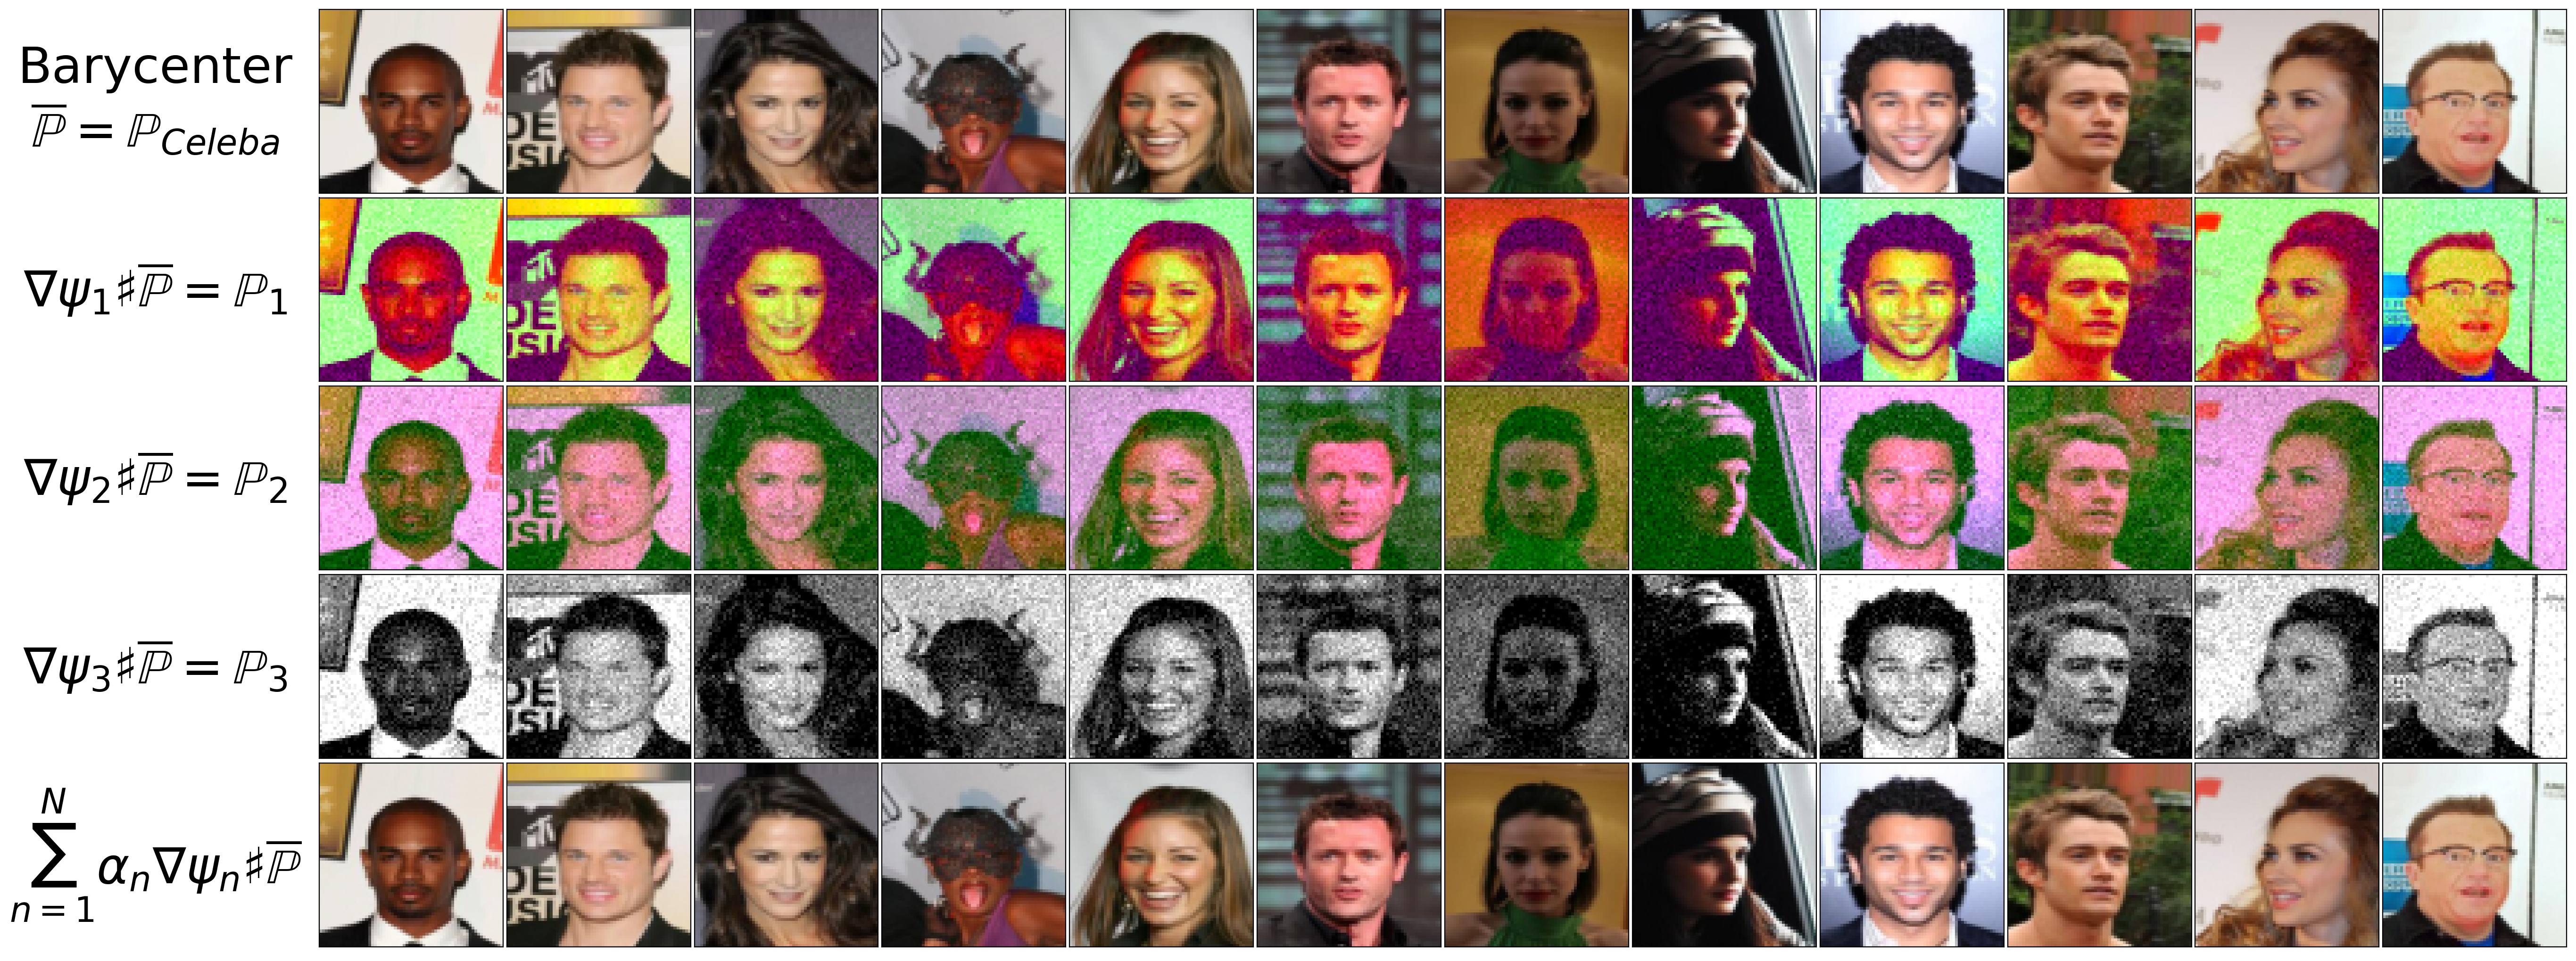

In [20]:
def to_img(x):
    return x.reshape(3,64,64).add(1).mul(0.5).to('cpu').detach().permute(1, 2, 0).numpy().clip(0,1)

fig, axes = plt.subplots(5, 12, figsize=(27.2, 10),dpi=200)
for i in range(12):
    X_avg = 0.
    for j in range(3):
        axes[j+1,i].imshow(to_img(X_samples[j][i])) #Normal
        X_avg += (X_samples[j][i] + X_bar_mean - X_samples_mean[j]) * alphas[j]
    axes[4,i].imshow(to_img(X_avg))
    axes[0,i].imshow(to_img(X_bar[i]))
    
for i in range(3):
    axes[i+1,0].set_ylabel(r'$\nabla\psi$' + f'$_{{{i+1}}}$' + r'$\sharp\overline{\mathbb{P}}=\mathbb{P}$' + f'$_{{{i+1}}}$', fontsize=38, rotation='horizontal', va="center", labelpad=125)
axes[4,0].set_ylabel(r'$\sum_{n=1}^{N}\alpha_{n}\nabla\psi_{n}\sharp\overline{\mathbb{P}}$', fontsize=38, rotation='horizontal', va="center", labelpad=125)
axes[0,0].set_ylabel('Barycenter\n' + r'$\overline{\mathbb{P}}=\mathbb{P}_{Celeba}$', fontsize=38, rotation='horizontal', va="center", labelpad=125)
    
for i, ax in enumerate(axes.flatten()):
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    
fig.tight_layout(pad=0.01)
torch.cuda.empty_cache(); gc.collect()

## Visualization of a trivial baseline maps

In [15]:
X_bar = torch.tensor(np.vstack([faces[parts_idx[i % 3][:4]] for i in range(72)]), device='cuda')
X_samples = marginals_from_bar(X_bar)

In [16]:
X_bar_mean = X_bar.mean(dim=0)
X_samples_mean = [X_samples[k].mean(dim=0) for k in range(len(X_samples))]

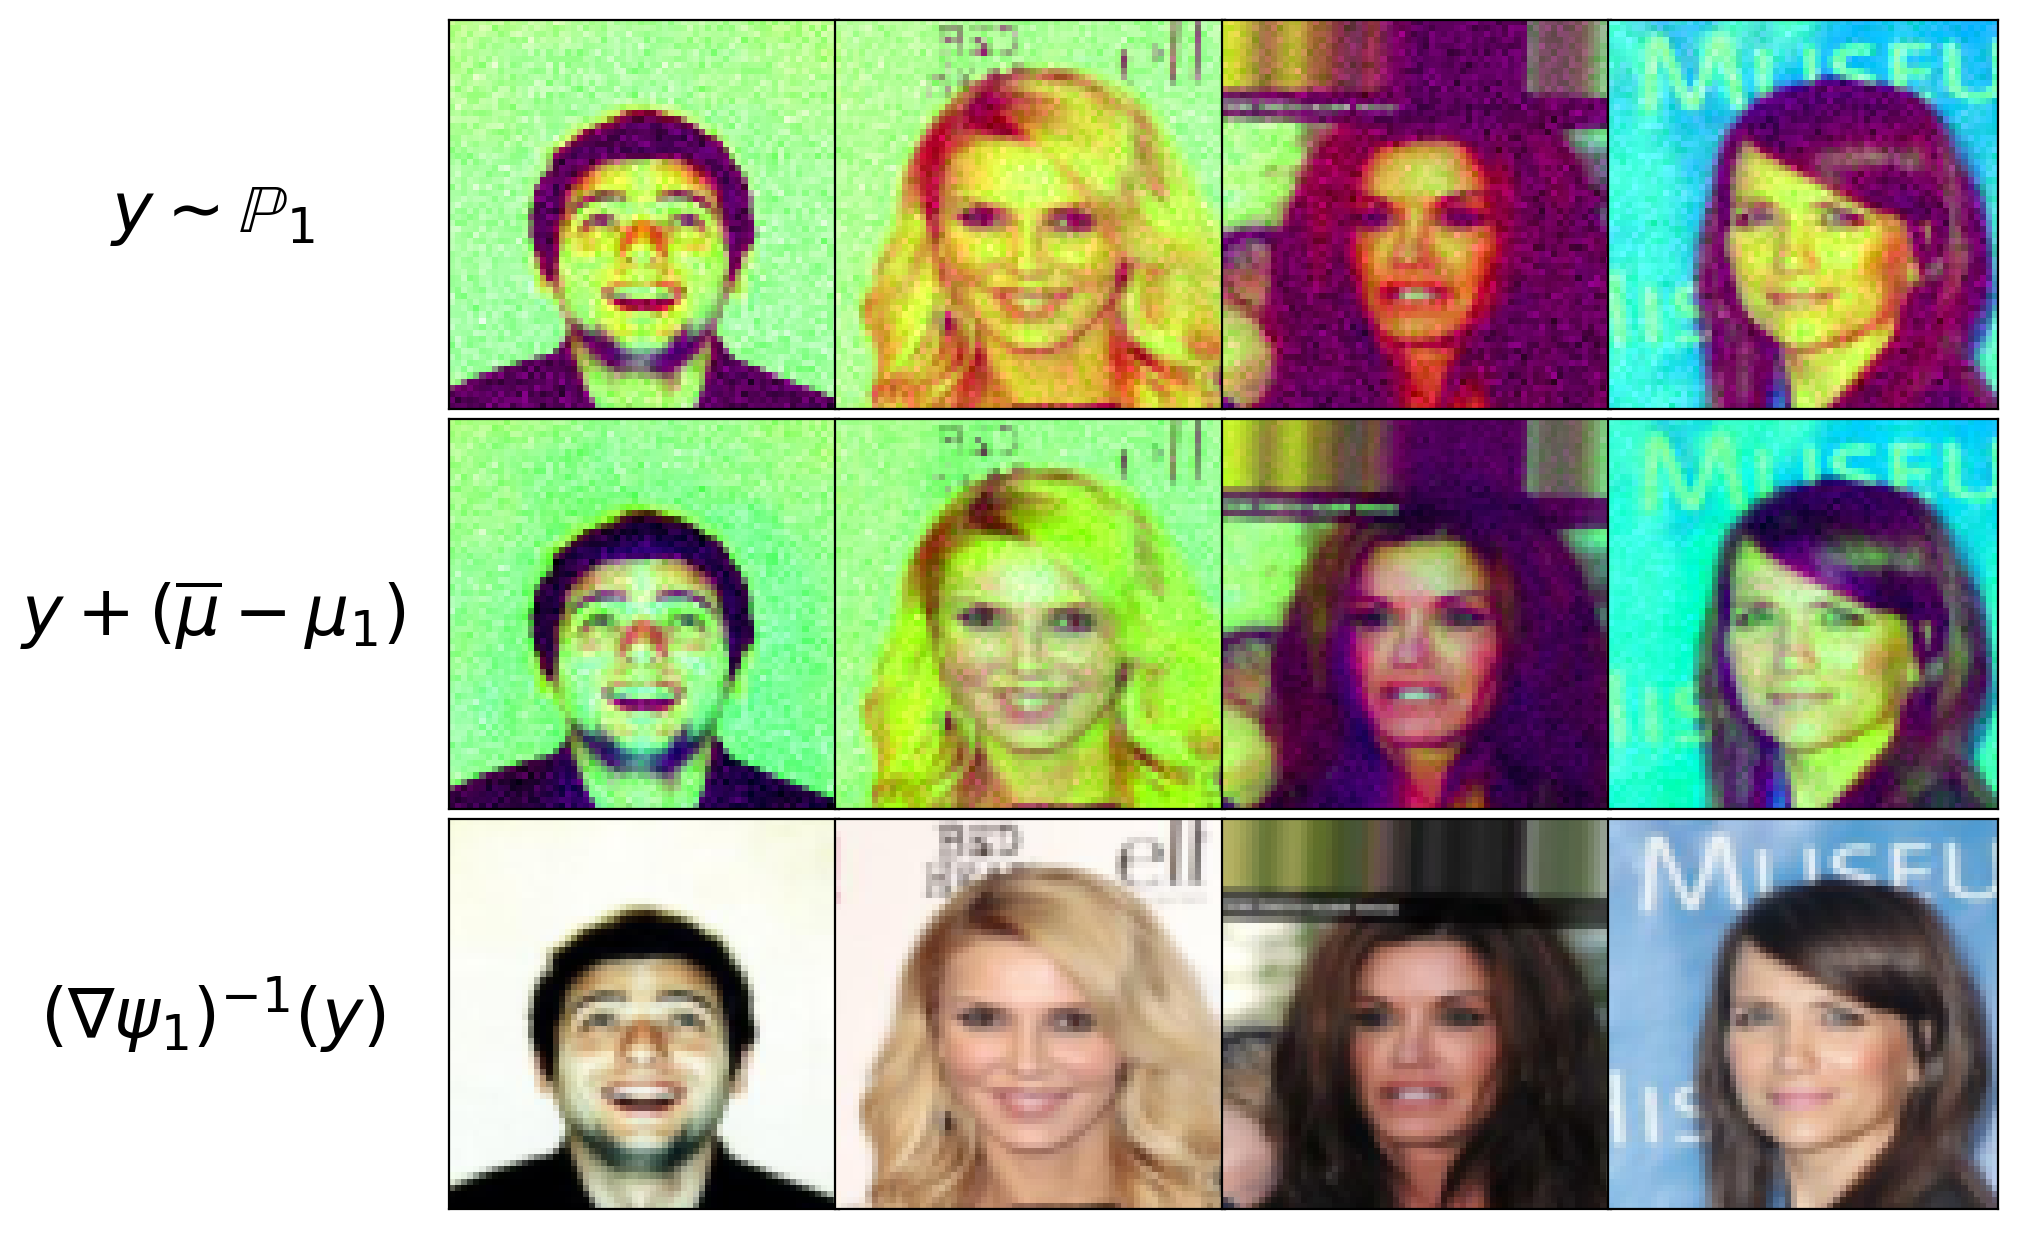

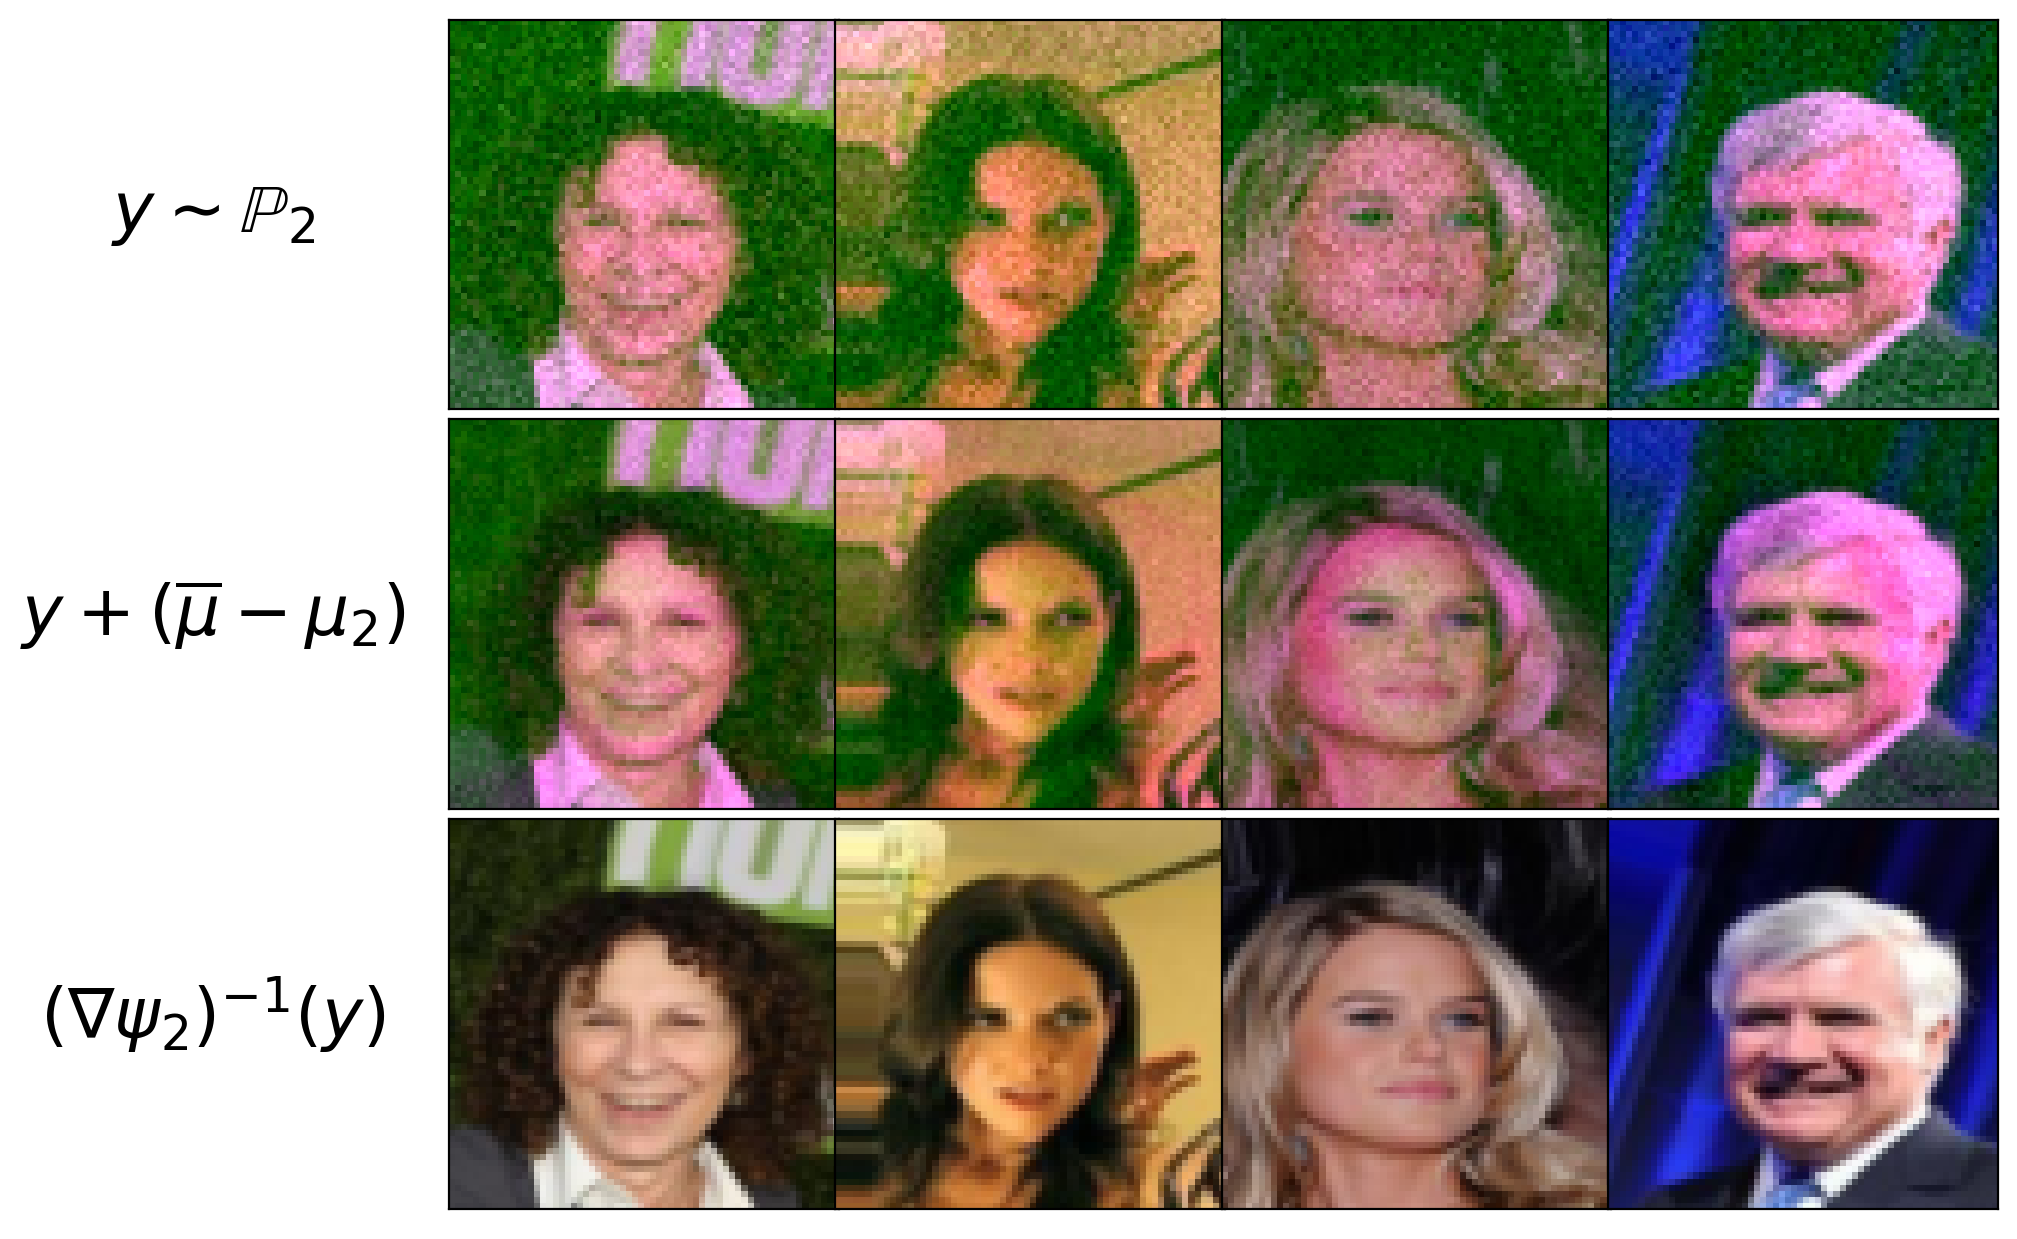

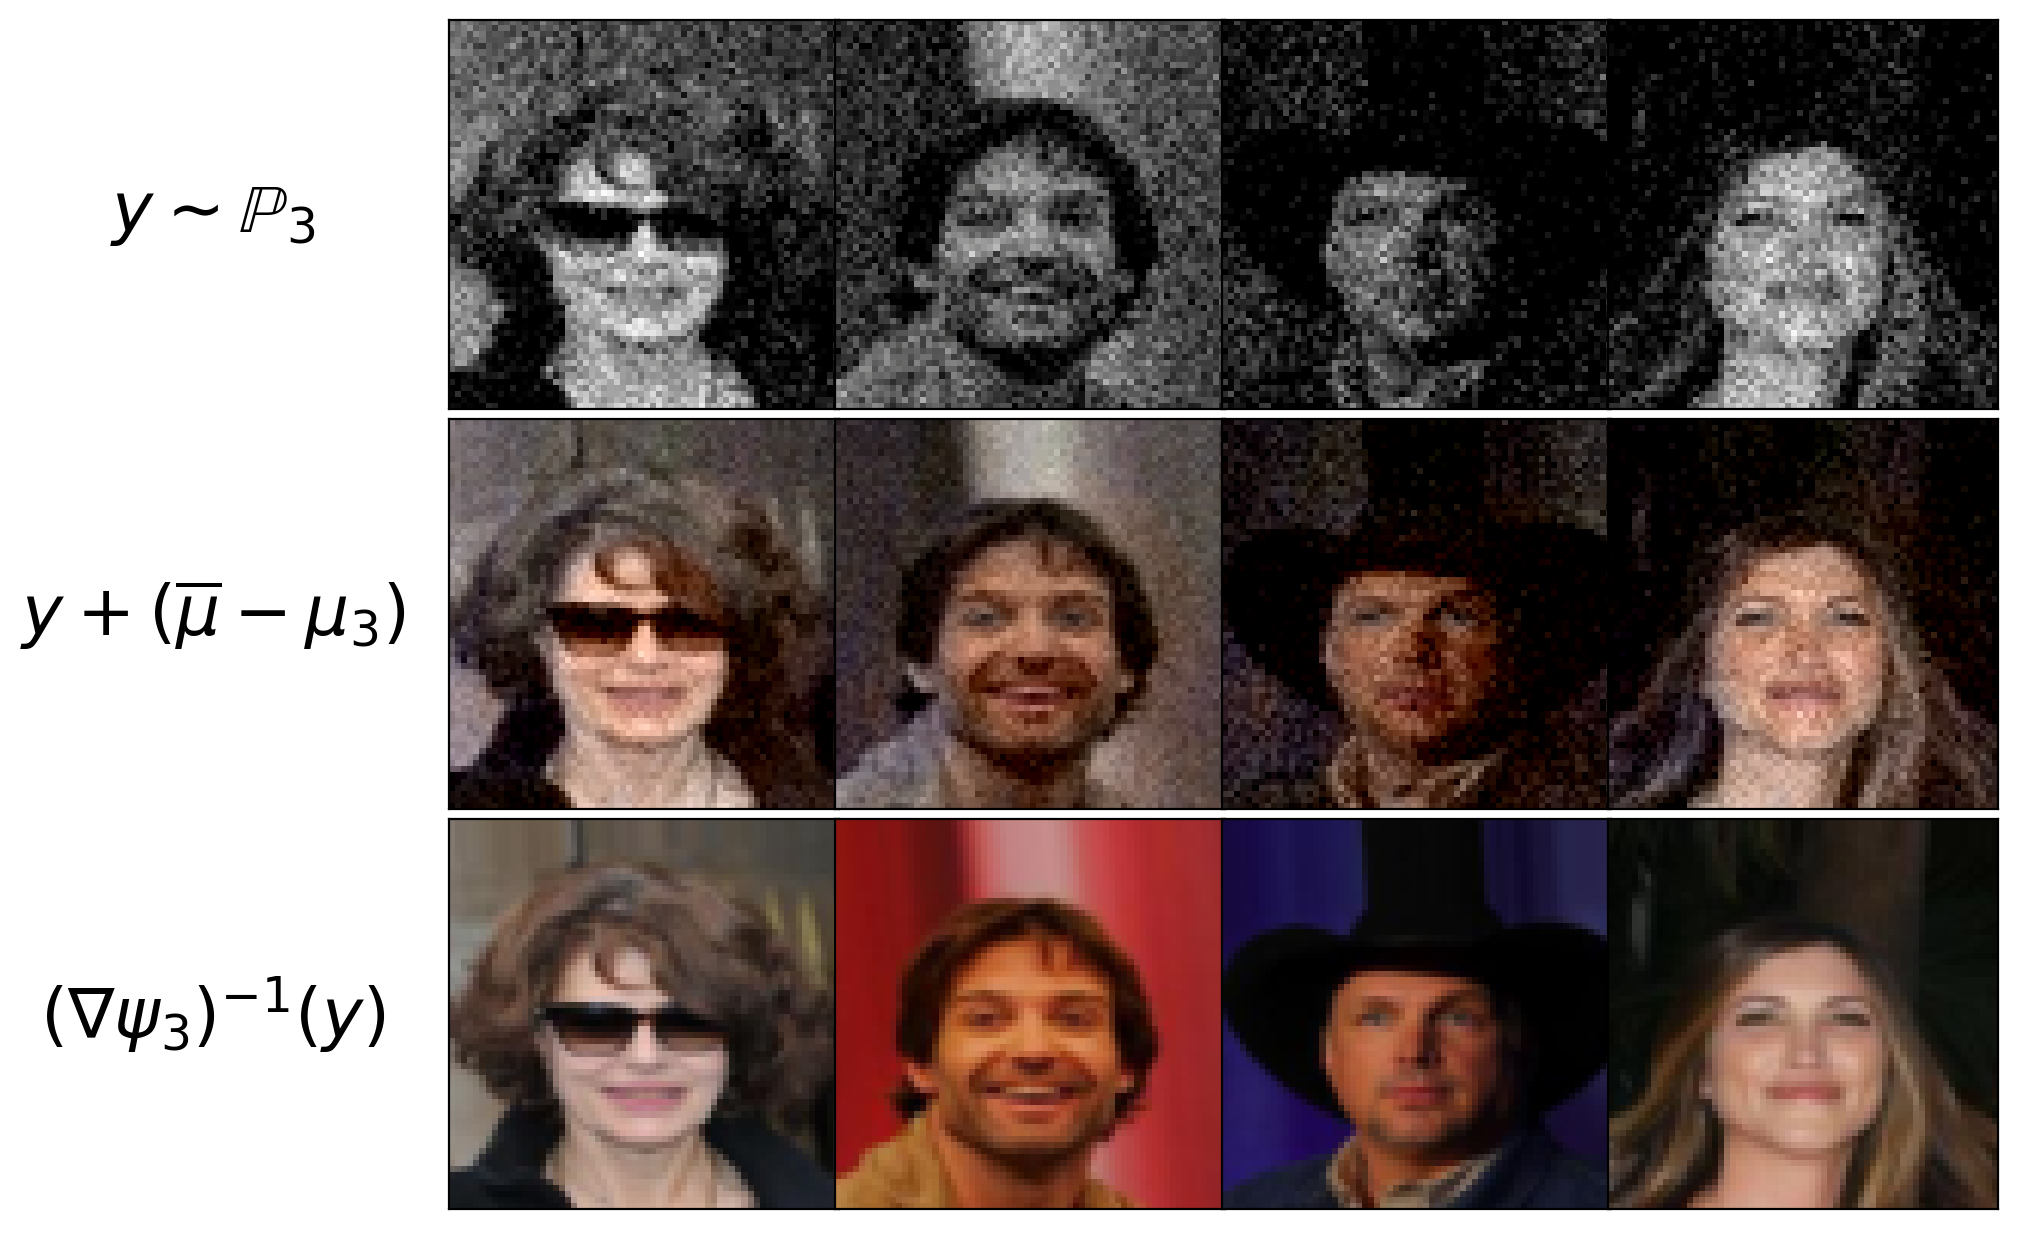

In [17]:
for k in range(3):
    fig, axes = plt.subplots(3, 4, figsize=(10, 6),dpi=200)
    for i in range(4):
        X_avg = 0.
        axes[0,i].imshow(to_img(X_samples[k][i+4*k])) 
        axes[1,i].imshow(to_img(X_samples[k][i+4*k] + X_bar_mean - X_samples_mean[k]))
        axes[2,i].imshow(to_img(X_bar[i+4*k]))

    axes[0,0].set_ylabel(r'$y\sim\mathbb{P}$' + f'$_{{{k+1}}}$', fontsize=25, rotation='horizontal', va="center", labelpad=85)
    axes[1,0].set_ylabel(r'$y+(\overline{\mu}-\mu$' + f'$_{{{k+1}}})$', fontsize=25, rotation='horizontal', va="center", labelpad=85)
    axes[2,0].set_ylabel(r'$(\nabla\psi$' + f'$_{{{k+1}}})$' + r'$^{-1}(y)$', fontsize=25, rotation='horizontal', va="center", labelpad=85)
    
    for i, ax in enumerate(axes.flatten()):
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])

    fig.tight_layout(pad=0.01)
    torch.cuda.empty_cache(); gc.collect()

## Creating marginal measures

In [18]:
torch.cuda.empty_cache()
gc.collect()

49269

In [19]:
which = [0] #[0, 1, 2] - separated to run in parallel on 3 GPUs
batchsize = 256

for k in which:
    for start in tqdm_notebook(range(0, len(parts_idx[k]), batchsize)):
        end = min(start+batchsize,len(parts_idx[k]))
        X_bar = torch.tensor(faces[parts_idx[k][start:end]], device='cuda')
        X_samples = marginals_from_bar(X_bar)
        for i in range(end-start):
            number = parts_idx[k][start+i]
            im = Image.fromarray((to_img(X_samples[k][i]) * 255).astype(np.uint8))
            im.save(os.path.join(path_out, str(k), str(number).zfill(6) + '.png'))

<ipython-input-19-3a91538f0b42>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for start in tqdm_notebook(range(0, len(parts_idx[k]), batchsize)):
